# Narrative Analystics and Experimentation - Employee Attrition

Dataset: HR Employee Attrition and Performance from IBM. This is a fictional dataset created by data scientists at IBM
https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/

Employee attrition is costly, and reduction of employee attrition rates should be pursued. In addition to the lost productivity that comes from having an unfilled role, there are also costs associated with finding, selecting, and training a new employee. Some estimates put the cost of an attrited employee at as much as one and a half times the employee's salary. The affect of high attrition on company culture and morale should also be considered. Improving attrition rates even slightly can significantly improve company operations, and exploring ways to do this is a worthwhile investment of resources.

Factors often thought to contribute to high employee attrition rate include salary and benefit considerations, employee engagement, and working conditions such as scheduling, environment, and company culture. This dataset  includes features related to these factors, and the analysis below will explore their impact on attrition. An experiment with the goal of reducing employee attrition will then be proposed based on the analysis.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
ibm = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [81]:
print(len(ibm.dtypes))
ibm.dtypes

35


Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears   

No     83.877551
Yes    16.122449
Name: Attrition, dtype: float64

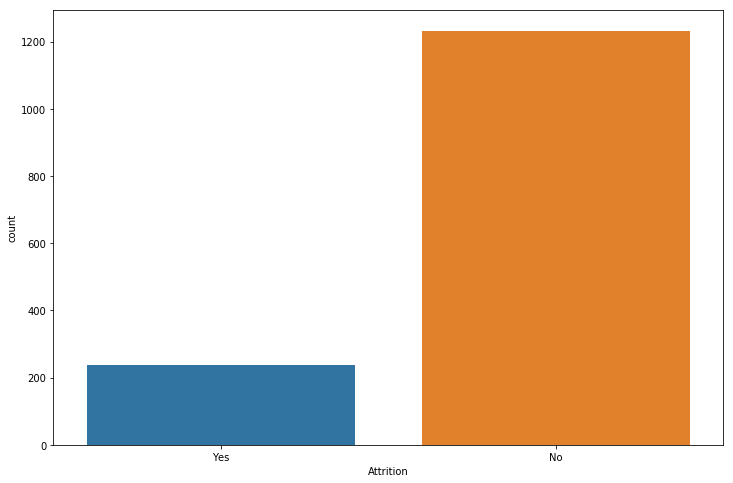

In [58]:
plt.figure(figsize=(12,8))
sns.countplot(x="Attrition", data=ibm)
ibm['Attrition'].value_counts()/ibm['Attrition'].count()*100
# We can see that the data contains 83.9% current employees and 16.1% former employees.

In [15]:
def chi2_matrix(df):
    '''computes pairwise chi2 p_values of categorical columns'''
    crt = []
#     cols = []
    for col1 in df.columns:
        if df[col1].dtype == 'object':
            crt.append([])
            for col2 in df.columns:
                if df[col2].dtype == 'object' and col1 == col2:
                    crt[-1].append(None)
                    
                if df[col2].dtype == 'object' and col1 != col2:
                    observed = pd.crosstab(df[col1], df[col2])
                    p_val = stats.chi2_contingency(observed)[1]
                    crt[-1].append(p_val)
    return pd.DataFrame(crt, index=[col for col in df.columns if df[col].dtype == 'object'], columns=[col for col in df.columns if df[col].dtype == 'object'])
        

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
Attrition,NaN,0.000006,4.525607e-03,6.773980e-03,0.290572,2.752482e-15,9.455511e-11,1.0,8.158424e-21
BusinessTravel,5.608614e-06,NaN,9.952355e-01,8.796489e-01,0.133229,7.448263e-01,1.116182e-01,1.0,2.400525e-01
Department,4.525607e-03,0.995236,NaN,7.771588e-214,0.227127,0.000000e+00,1.556705e-01,1.0,9.542751e-01
EducationField,6.773980e-03,0.879649,7.771588e-214,NaN,0.709016,1.723301e-155,4.776135e-01,1.0,8.814816e-01
Gender,2.905724e-01,0.133229,2.271270e-01,7.090163e-01,NaN,4.195444e-02,1.696666e-01,1.0,1.215481e-01
JobRole,2.752482e-15,0.744826,0.000000e+00,1.723301e-155,0.041954,NaN,4.246433e-02,1.0,5.838314e-01
MaritalStatus,9.455511e-11,0.111618,1.556705e-01,4.776135e-01,0.169667,4.246433e-02,NaN,1.0,6.647391e-01
Over18,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,NaN,1.000000e+00
OverTime,8.158424e-21,0.240053,9.542751e-01,8.814816e-01,0.121548,5.838314e-01,6.647391e-01,1.0,NaN


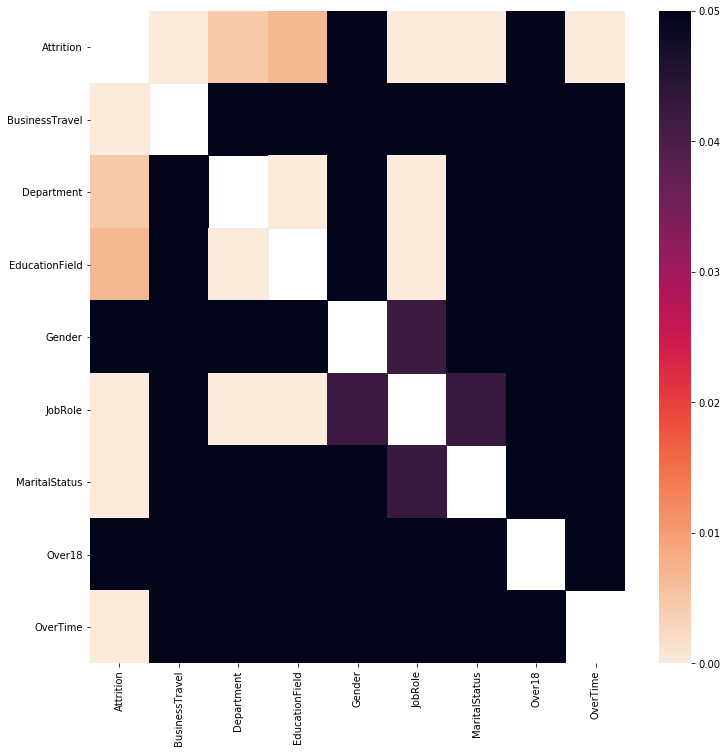

In [17]:
plt.figure(figsize=(12,12))
sns.heatmap(chi2_matrix(ibm), vmax=.05, cmap=sns.cm.rocket_r)
chi2_matrix(ibm)


When tested for independence against all the other categorical variables in the dataset, Attrition is significantly (p < .05) related to all other categorical variables except for Gender and Over18 (whether or not an employee is over 18). The categories with the lowest p_values are MaritalStatus and OverTime (whether or not an employee works overtime). Both are interesting because they themselves are not significantly related to the other categorical variables (with the exception of marital status and job role).

In [18]:
def anova_matrix(df):
    '''computes pairwise one way f test p_values of columns (categorical + continuous pairs)'''
    art = []
#     cols = []
    for col1 in df.columns:
        if df[col1].dtype == 'object':
            art.append([])
            for col2 in df.columns:
                if df[col2].dtype != 'object':
                    observed = []
                    for cat in df[col1].unique():
                        sample = df[df[col1]==cat][col2]
                        observed.append(sample)
                    p_val = stats.f_oneway(*observed)[1]
                    art[-1].append(p_val)
    return pd.DataFrame(art, index=[col for col in df.columns if df[col].dtype == 'object'], columns=[col for col in df.columns if df[col].dtype != 'object'])
        


c:\python36-32\lib\site-packages\scipy\stats\stats.py:2933: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw
c:\python36-32\lib\site-packages\scipy\stats\stats.py:2931: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / float(dfbn)


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,8.356308e-10,0.029858,0.002793,0.229315,NaN,0.685328,0.000072,0.793135,5.677065e-07,6.795385e-11,...,0.078714,NaN,1.301015e-07,4.061878e-11,0.022578,0.014211,2.318872e-07,6.003186e-10,2.057900e-01,1.736987e-09
BusinessTravel,5.357095e-01,0.835387,0.625788,0.943609,NaN,0.685045,0.888126,0.569580,2.131701e-01,6.512843e-01,...,0.334004,NaN,4.926219e-01,4.200876e-01,0.724854,0.888716,8.226669e-01,8.982030e-01,4.268796e-01,6.822219e-01
Department,4.652855e-01,0.568635,0.790580,0.753510,NaN,0.033345,0.562964,0.700997,6.058825e-01,6.007018e-05,...,0.405856,NaN,8.098843e-01,8.332249e-01,0.234757,0.014979,4.669032e-01,8.475646e-02,2.946001e-01,3.843052e-01
EducationField,3.473002e-01,0.059362,0.682913,0.006026,NaN,0.799340,0.163993,0.305161,9.636194e-01,6.522578e-03,...,0.479409,NaN,3.059496e-01,4.137280e-01,0.085436,0.566662,6.489371e-01,6.575440e-01,6.068602e-01,7.003923e-01
Gender,1.640914e-01,0.653549,0.943485,0.526134,NaN,0.387486,0.984464,0.985382,4.914168e-01,1.310335e-01,...,0.380946,NaN,6.261642e-01,7.235128e-02,0.137173,0.916019,2.543686e-01,1.118792e-01,3.011771e-01,2.410139e-01
JobRole,2.464075e-61,0.923757,0.618147,0.001394,NaN,0.198507,0.283753,0.896731,6.628700e-01,0.000000e+00,...,0.780643,NaN,7.559231e-01,1.756740e-175,0.173598,0.072912,1.834160e-64,1.310128e-32,3.061298e-25,3.607289e-31
MaritalStatus,2.515486e-05,0.013517,0.469260,0.986647,NaN,0.117831,0.676646,0.330185,2.223090e-01,3.679709e-03,...,0.201204,NaN,3.997636e-197,2.703251e-03,0.506818,0.839988,2.471781e-02,3.498576e-03,7.495268e-02,1.850107e-01
Over18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverTime,2.822747e-01,0.726377,0.328305,0.436235,NaN,0.357075,0.007147,0.765615,8.931374e-01,9.833722e-01,...,0.063062,NaN,9.862869e-01,6.251179e-01,0.002402,0.299258,6.543516e-01,2.541941e-01,6.391683e-01,1.109888e-01


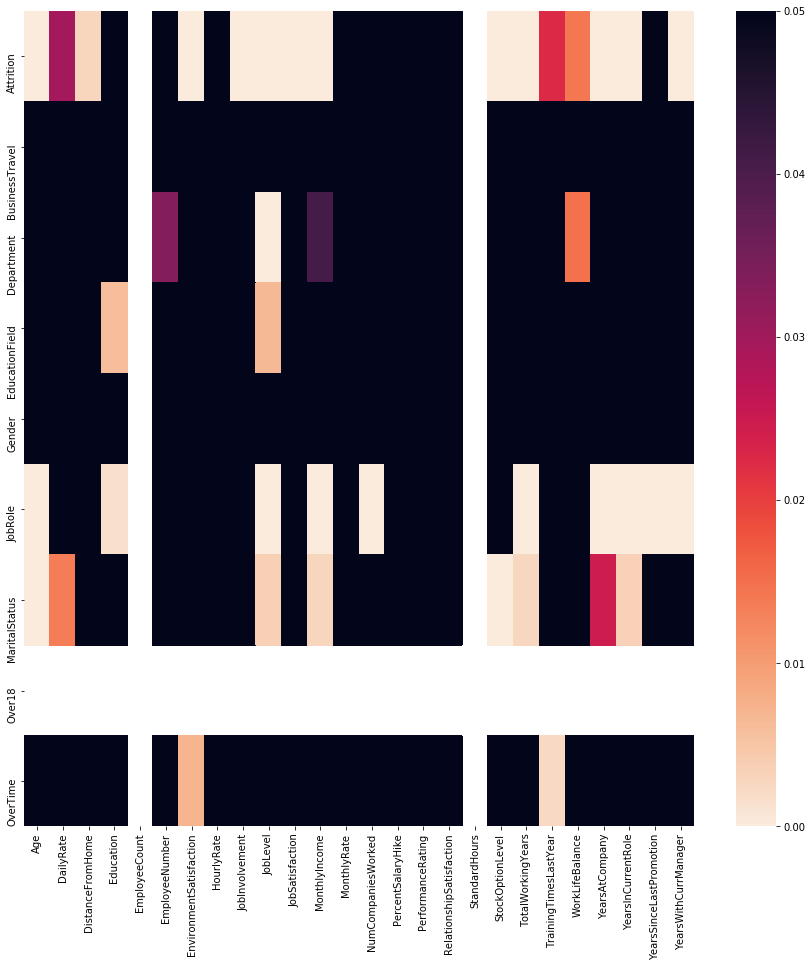

In [20]:
plt.figure(figsize=(15,15))
sns.heatmap(anova_matrix(ibm), vmax=.05, cmap=sns.cm.rocket_r)
anova_matrix(ibm)

We can see that many attrition is significantly related to many continuous categories as well. Again it is interesting to note that OverTime is not significantly related to many continuous categories.

Overtime will be the basis around which we make an experiment. This is for a few reasons. One is that overtime is significantly related to attrition. Within this dataset, former employees were significantly more likely to have worked overtime than current employees, and workers that worked overtime were more likely to be former employees than workers who did not work overtime. The notion that working employees overtime can lead to increased attrition seems plausible. Scheduling is among the factors commonly thought to be a significantly related employee attrition. Another attractive quality of overtime is that it is not significantly related to many other variables in the dataset which should decrease our chances of being fooled by a lurking variable. Finally, overtime as it is presented here is a simple variable to understand (did they or did they not work more than 40 hours?) and it is well suited for A\B testing (stop some employees from working overtime and observe the difference). 

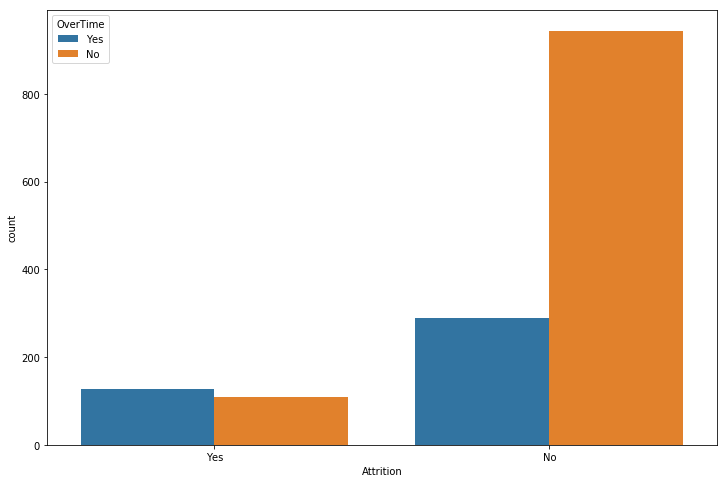

In [59]:
plt.figure(figsize=(12,8))
sns.countplot(x="Attrition", data=ibm, hue='OverTime')


In [86]:
#number of current employees working overtime
len(ibm[(ibm['Attrition']=='No') & (ibm['OverTime']=='Yes')])

289

There are currently 289 current employees working overtime. We will split this group randomly in half (or as close as possible). Group 1 (145 employees) which will continue with business as usual and group 2 (144 employees) which will be prevented from working overtime. In real life, it may not be so easy to randomly eliminate overtime for some without changing anything else. For purposes of this exercise we will ignore this.

Because this dataset is fictional, the timeframe that this dataset covers is unclear. For the purposes of this assignment we will assume the data is taken from a single year of business, meaning the 16.1% (237) of former employees included in the dataset will be assumed to have departed the company all within the span of a single year. 

In [133]:
# over all attrition rate
ar = len(ibm[ibm['Attrition']=='Yes'])/len(ibm)
# non-overtime attrition rate
not_ar = len(ibm[(ibm['OverTime']=='No') & (ibm['Attrition']=='Yes')])/len(ibm[ibm['OverTime']=='No'])
# overtime attrition rate
ot_ar = len(ibm[(ibm['OverTime']=='Yes') & (ibm['Attrition']=='Yes')])/len(ibm[ibm['OverTime']=='Yes'])

print('attrition rate: {}%\nnon-overtime attrition rate: {}%\novertime attrition rate: {}%'.format(round(100*ar,2),round(100*not_ar,2), round(100*ot_ar,2)))

attrition rate: 16.12%
non-overtime attrition rate: 10.44%
overtime attrition rate: 30.53%


In [129]:
for i in range(12):
    ena = int((15/12)*(i+1)) # expected non-overtime atrittion count
    eoa = int((43/12)*(i+1)) # expected overtime attrition count
    p_val = proportions_ztest([ena,eoa],[144,145])[1]
    print('month {} expected p_val: {}'.format((i+1), round(p_val,3)))

month 1 expected p_val: 0.317
month 2 expected p_val: 0.092
month 3 expected p_val: 0.048
month 4 expected p_val: 0.034
month 5 expected p_val: 0.018
month 6 expected p_val: 0.006
month 7 expected p_val: 0.002
month 8 expected p_val: 0.002
month 9 expected p_val: 0.001
month 10 expected p_val: 0.0
month 11 expected p_val: 0.0
month 12 expected p_val: 0.0


This test of overtime will continue until either a significant difference (at p < .05) is reached or until one year has passed. Continuing the test for an entire year should help catch any seasonal differences in overall attrition rate. If a significant difference in attrition is reached (with the overtime group's attrition rate being larger), then we will conclude that working employees overtime does contribute to increased attrition, and we will evaluate the most efficient ways to reduce the number of employees working overtime (new hires, outsourcing, narrower focus of work...). 

Of the employees that work overtime, the attrition rate looks to be 30.53% per year while it is only 10.44% per year among employees that do not work overtime. If this rate were to continue it would take approximately 3 months to reach a significant difference between the groups (with a criteria of p < .05).